In [12]:
import spacy
!spacy download en
!spacy download fr
!pip install torchtext==0.6.0

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
SEED = 2222

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')

In [0]:
def tokenize_fr(text):
    
    return [tok.text for tok in spacy_fr.tokenizer(text)][::-1]

def tokenize_en(text):
    
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.fr', '.en'), 
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [15]:
!ls .data/multi30k

mmt_task1_test2016.tar.gz  test2016.fr	train.fr	 val.en
test2016.de		   train.de	training.tar.gz  val.fr
test2016.en		   train.en	val.de		 validation.tar.gz


In [0]:
!cp val.fr .data/multi30k/

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        embedded = self.dropout(self.embedding(src))
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

class Attention(nn.Module):

    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        batch_size = encoder_outputs.shape[1]

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 

        attention = self.v(energy).squeeze(2)
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

class Decoder(nn.Module):

    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
       
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        
        a = self.attention(hidden, encoder_outputs, mask)
        
        a = a.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        weighted = torch.bmm(a, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder

        self.decoder = decoder

        self.src_pad_idx = src_pad_idx

        self.device = device
        
    def create_mask(self, src):

        mask = (src != self.src_pad_idx).permute(1, 0)

        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
       
        batch_size = src.shape[1]

        trg_len = trg.shape[0]

        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        input = trg[0,:]
        
        mask = self.create_mask(src)

        for t in range(1, trg_len):
            
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1
            
        return outputs

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,014,476 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)

            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [20]:
N_EPOCHS = 20
CLIP = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Epoch: 01 | Time: 0m 25s
	Train Loss: 5.318 | Train PPL: 203.906
	 Val. Loss: 4.892 |  Val. PPL: 133.278
Epoch: 02 | Time: 0m 25s
	Train Loss: 4.515 | Train PPL:  91.402
	 Val. Loss: 4.827 |  Val. PPL: 124.849
Epoch: 03 | Time: 0m 25s
	Train Loss: 4.196 | Train PPL:  66.436
	 Val. Loss: 4.579 |  Val. PPL:  97.399
Epoch: 04 | Time: 0m 25s
	Train Loss: 3.920 | Train PPL:  50.376
	 Val. Loss: 4.229 |  Val. PPL:  68.637
Epoch: 05 | Time: 0m 25s
	Train Loss: 3.493 | Train PPL:  32.883
	 Val. Loss: 3.825 |  Val. PPL:  45.833
Epoch: 06 | Time: 0m 24s
	Train Loss: 3.066 | Train PPL:  21.459
	 Val. Loss: 3.576 |  Val. PPL:  35.722
Epoch: 07 | Time: 0m 25s
	Train Loss: 2.646 | Train PPL:  14.101
	 Val. Loss: 3.210 |  Val. PPL:  24.784
Epoch: 08 | Time: 0m 25s
	Train Loss: 2.385 | Train PPL:  10.860
	 Val. Loss: 3.122 |  Val. PPL:  22.683
Epoch: 09 | Time: 0m 25s
	Train Loss: 2.063 | Train PPL:   7.873
	 Val. Loss: 3.184 |  Val. PPL:  24.131
Epoch: 10 | Time: 0m 24s
	Train Loss: 1.943 | Train PPL

In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('fr')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


src = ['vtt', 'un', 'tenant', ',', 'debout', 'est', 'pêche', 'débardeur', 'un', 'avec', 'souriante', 'femme', 'une']
trg = ['a', 'smiling', 'woman', 'in', 'a', 'peach', 'tank', 'top', 'stands', 'holding', 'a', 'mountain', 'bike']
predicted trg = ['a', 'smiling', 'woman', 'with', 'a', 'yellow', 'is', 'standing', 'standing', 'holding', 'a', 'bike', '.', '<eos>']


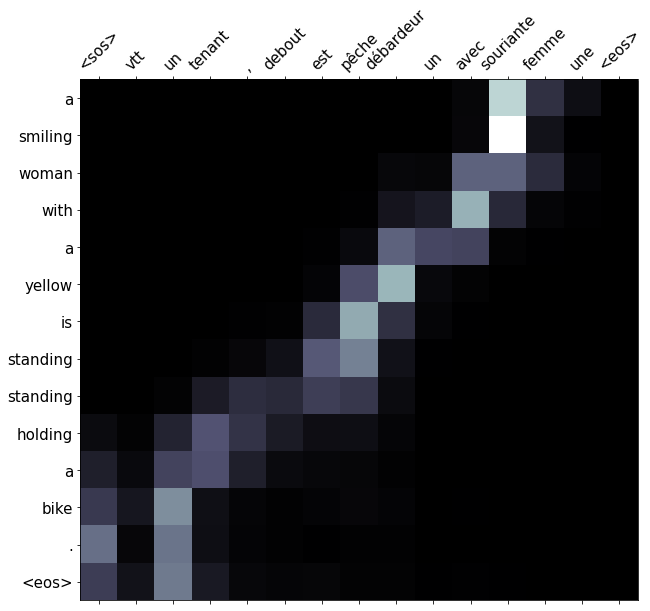

In [22]:
example_idx = 9

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [23]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 38.41
